In [1]:
# Here we implement a controller driven by neural network architecture to select per time step the input frequencies of a standing wave

import argparse
import os
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np

import taichi as ti

[Taichi] version 1.7.0, llvm 15.0.1, commit 2fd24490, win, python 3.10.10


In [2]:
import sys; sys.argv=['']; del sys

In [34]:
ti.init(arch=ti.cpu) #initialization arch ti.cpu/ti.gpu
G = 1 # gravitataional constant is 6.67408e-11, using 1 here for simplicity
PI = 3.1415926
res = 512
# global control
paused = ti.field(ti.i32, ()) # a scalar i32

N = 100 # number of planets
planet_m_max = 5.0 # mass 
galaxy_size = 0.6 # galaxy size
planet_radius_max = 10.0 / float(res) # planet radius for rendering
init_vel = 100.0 # inital veclocity

# a big planet
M = 1000.0
big_planet_radius = 30.0 / float(res)

# hale
#start = ti.field(ti.i32, shape = ())
#ishale = ti.field(ti.i32, shape = N)

h = 1e-5 # time stpe
substepping = 10 # the number of sub-iterations within a time step

#declare fields (pos, vel, force of the planets)
# 2d problem
pos = ti.Vector.field(2, ti.f32, N)
pos_1 = ti.Vector.field(2, ti.f32, 1)
vel = ti.Vector.field(2, ti.f32, N)
vel_p1 = ti.Vector.field(2, ti.f32, N)
force = ti.Vector.field(2, ti.f32, N)
Ishaled = ti.field(ti.i32, N)

planet_radius = ti.field(ti.f32, N)
planet_m = ti.field(ti.f32, N)

big_pos = ti.Vector.field(2, ti.f32, 1)
big_pos[0] = [0.5, 0.5] # initial position of the big planet

energy = ti.field(ti.f32, shape = 2) # [1] current energy [0] inital energy
planet_color = ti.Vector.field(3, ti.f32, N)

# Acoustic properties
po = 10e6 # acoustic pressure level 1 
# pxy = [1,0.2]
# k = [3,3]

ax = np.array([1.0, 0.5])
ay = np.array([0.2, 0.3])
kx = np.array([3, 4])
ky = np.array([2, 1])

# convert arrays into Taichi fields 
ax_field = ti.field(dtype=ti.f32, shape=ax.shape)
ay_field = ti.field(dtype=ti.f32, shape=ay.shape)
kx_field = ti.field(dtype=ti.f32, shape=kx.shape)
ky_field = ti.field(dtype=ti.f32, shape=ky.shape)

ax_field.from_numpy(ax)
ay_field.from_numpy(ay)
kx_field.from_numpy(kx)
ky_field.from_numpy(ky)

num_waves_x = ti.field(dtype=ti.i32, shape=())
num_waves_y = ti.field(dtype=ti.i32, shape=())
num_waves_x[None] = len(ax)
num_waves_y[None] = len(ay)

# drag properties 
drag = 1e6

    
@ti.kernel
def initialize(): #initialize pos, vel, force of each planet
    center = ti.Vector([0.5,0.5])
    for i in range(N):
        theta = ti.random() * 2 * PI  # theta = (0, 2 pi)
        r = (ti.sqrt(ti.random()) * 0.7 + 0.3) * galaxy_size # r = (0.3 1)*galaxy_size
        offset = r * ti.Vector([ti.cos(theta), ti.sin(theta)]) #
        pos[i] = center + offset
        vel[i] = [-offset.y, offset.x] # vel direction is perpendicular to its offset
        vel[i] *= init_vel
        
        planet_radius[i] = max(0.4,ti.random()) * planet_radius_max
        planet_m[i] = (planet_radius[i] / planet_radius_max)**2 * planet_m_max

        energy[0] += 0.5 * planet_m[i] * (vel[i][0]**2 + vel[i][1]**2)
        energy[1] += 0.5 * planet_m[i] * (vel[i][0]**2 + vel[i][1]**2)
        
        planet_color[i][0] = 1 - planet_m[i] / planet_m_max
        planet_color[i][1] = 1 - planet_m[i] / planet_m_max
        planet_color[i][2] = 1 - planet_m[i] / planet_m_max
        
@ti.kernel
def compute_force():

    #clear force
    for i in range(N):
        force[i] = ti.Vector([0.0, 0.0])
    
    #compute acoustic force
    for i in range(N):
        # f = po * (ti.sin(2*PI*kx*pos[i][0])) 
        # force[i][0] += f # acoustic force on planet i
        
        # f = po * (ti.sin(2*PI*pos[i]*k))*pxy 
        
        f_x = 0.0
        f_y = 0.0
        
        for wave in range(num_waves_x[None]):
            f_x += ax_field[wave] * ti.sin(2 * PI * pos[i][0] * kx_field[wave])
        
        for wave in range(num_waves_y[None]):
            f_y += ay_field[wave] * ti.sin(2 * PI * pos[i][1] * ky_field[wave])            
        
        # Compute total force for this position
        f_vector = ti.Vector([f_x, f_y]) * po
        force[i] += f_vector  
        
        # force[i] += f # acoustic force on planet i



    # force due to drag
    for i in range(N):
        f = -drag * planet_radius[i] * vel[i]
        force[i] += f

@ti.kernel  
def update():  # update each planet's vel and pos based on gravity 
    dt = h/substepping # time step 
    for i in range(N):
        
        # if Ishaled[i] == 0:

            vel[i] += dt * force[i] / planet_m[i]
            #vel[i][1] -= dt * 1000000
            pos[i] += dt * vel[i]
            # collision detection at edges, flip the velocity
            if pos[i][0] < 0.0 + planet_radius[i] or pos[i][0] > 1.0 - planet_radius[i]:
                vel[i][0] *= -1
            if pos[i][1] < 0.0 + planet_radius[i] or pos[i][1] > 1.0 - planet_radius[i]:
                vel[i][1] *= -1
        #elif Ishaled[i] ==1:
            #pos[i] = [-1, -1]
            #vel[i] = [0, 0]

        # collisions between particles 1: brute force 2: grid parition
    

@ti.kernel  
def collision_update(): # 1: brute force
    
    for i in range(N):
        for j in range(N):
            if i != j:
                diff  = pos[i] - pos[j]
                r = diff.norm(1e-4) #norm of Vector diff and minimum value is 1e-5 (clamp to 1e-5)
                if r <=  (planet_radius[i] + planet_radius[j]):
                    #dot = (vel[i] - vel[j]).dot(diff)
                    vel_diff = vel[i] - vel[j]
                    #print(dot_vx)
                    dot_vx = min(diff[0] * vel_diff[0] + diff[1] * vel_diff[1],-1e-2)
                    #if dot_vx / vel_diff.norm() /diff.norm()   >= -0.1 and dot_vx / vel_diff.norm() /diff.norm() <= 0.1:
                        #print(dot_vx)
                       # dot_vx = 0.0
                    vel_p1[i] = vel_p1[i] - 2*planet_m[j]/(planet_m[i]+planet_m[j])*dot_vx/r**2*diff * (energy[0] / energy[1])
                    #vel_p1[i] = vel_p1[i] - -1e2*diff
                    #vel[i][0] *= -1
                    #vel[i][1] *= -1
                                      
    for i in range(N):
        diff = pos[i] - big_pos[0]
        r = diff.norm(1e-4)
        if r <=  (planet_radius[i] + big_planet_radius):
                #vel_p1[i][0] = -1.0 * vel[i][0]
                #vel_p1[i][1] = -1.0 * vel[i][1]
                vel_diff = vel[i] - 0.0
                dot_vx = min(diff[0] * vel_diff[0] + diff[1] * vel_diff[1],-1e-2) 
                #print(dot_vx)
                #if dot_vx / vel_diff.norm() /diff.norm()   >= -0.1 and dot_vx / vel_diff.norm() /diff.norm() <= 0.1:
                   # dot_vx = 0.0
                vel_p1[i] = vel[i] - 2*M/(planet_m[i]+M)*dot_vx/r**2*diff * (energy[0] / energy[1])
                # term : (energy[0] / energy[1]) is to help conserve kinetic energy

                #vel_p1[i] = vel_p1[i] - -1e2*diff

@ti.kernel  
def compute_enery(): 
    
    energy[1] = 0.0
    for i in range(N):
        energy[1] += 0.5 * planet_m[i] * (vel[i][0]**2 + vel[i][1]**2)

[Taichi] Starting on arch=x64


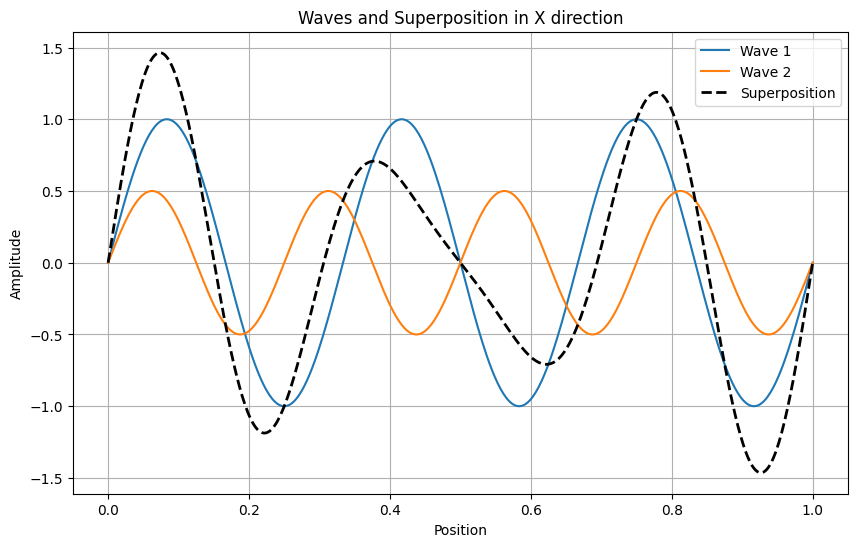

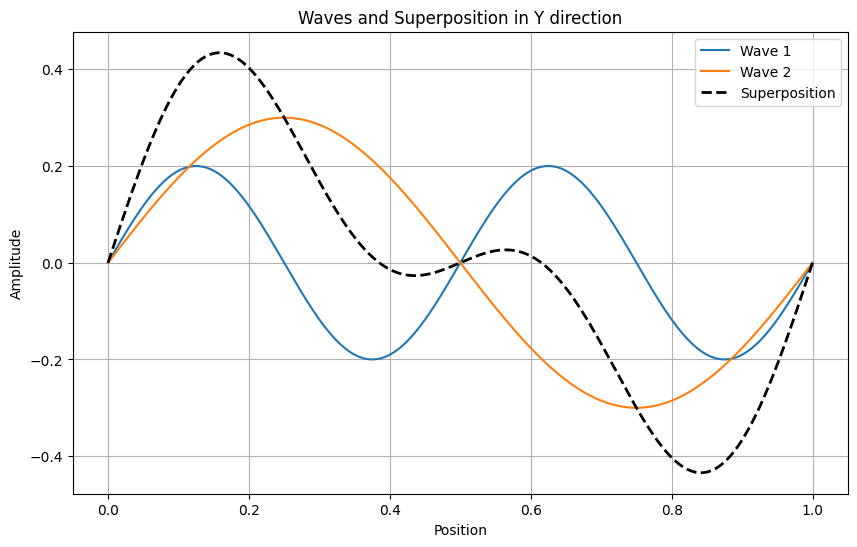

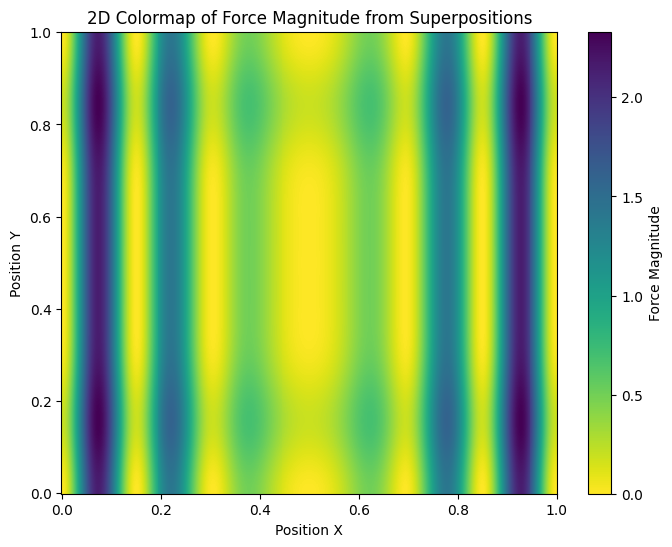

In [38]:
import matplotlib.pyplot as plt

positions = np.linspace(0, 1, 500)

# Compute wave values and superpositions
def compute_waves(amplitudes, wavenumbers, positions):
    num_waves = len(amplitudes)
    wave_values = np.zeros((num_waves, len(positions)))
    for i in range(num_waves):
        wave_values[i, :] = amplitudes[i] * np.sin(2 * np.pi * positions * wavenumbers[i])
    superposition = np.sum(wave_values, axis=0)
    return wave_values, superposition

# Compute for x and y
wave_values_x, superposition_x = compute_waves(ax, kx, positions)
wave_values_y, superposition_y = compute_waves(ay, ky, positions)

# Plotting
def plot_waves_and_superposition(wave_values, superposition, positions, title):
    plt.figure(figsize=(10, 6))
    for i in range(wave_values.shape[0]):
        plt.plot(positions, wave_values[i, :], label=f'Wave {i+1}')
    plt.plot(positions, superposition, label='Superposition', color='black', linewidth=2, linestyle='--')
    plt.title(title)
    plt.xlabel('Position')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

# Plot for x
plot_waves_and_superposition(wave_values_x, superposition_x, positions, 'Waves and Superposition in X direction')

# Plot for y
plot_waves_and_superposition(wave_values_y, superposition_y, positions, 'Waves and Superposition in Y direction')


# Create a 2D grid of positions
X, Y = np.meshgrid(positions, positions)

# Calculate the force magnitude at each point in the grid
# Assume the superposition in x affects the x component of the force and y affects the y component
Force_x = np.outer(np.ones_like(positions), superposition_x)
Force_y = np.outer(superposition_y, np.ones_like(positions))
Force_magnitude = np.sqrt(Force_x**2 + Force_y**2)

# Plotting the 2D colormap of force magnitudes
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, Force_magnitude**2, shading='auto', cmap='viridis_r')
plt.colorbar(label='Force Magnitude')
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.title('2D Colormap of Force Magnitude from Superpositions')
plt.show()

In [36]:
#start the simulation
gui = ti.GUI('N-body problem', (res, res)) # create a window of resolution 512*512

'''
rgb = (0.4, 0.8, 1) # RGB color (0,0,0) = black, (1,1,1) = white
hex = ti.rgb_to_hex(rgb)
rgb2 = ti.hex_to_rgb(hex)
print(int(hex))
print(rgb2)
'''
initialize()

while gui.running: # update frames, intervel is time step h

    for e in gui.get_events(ti.GUI.PRESS): #event processing
        if e.key == ti.GUI.ESCAPE:  # 'Esc'
            exit()
        elif e.key == 'r':  # 'r'
            initialize()
        elif e.key == ti.GUI.SPACE:  # 'space'
            paused[None] = not paused[None]
       # elif e.key == ti.GUI.LMB:
        #    big_pos[0] = [e.pos[0], e.pos[1]]
    if(gui.is_pressed(ti.GUI.LMB)):
        big_pos[0] = [gui.get_cursor_pos()[0], gui.get_cursor_pos()[1]]
            
            
            
    if not paused[None]:
        for i in range(substepping): # run substepping times for each time step
            compute_force()
            update()
            vel_p1.copy_from(vel)
            collision_update()
            vel.copy_from(vel_p1)
            compute_enery()
            # print('Current energy = {}, Initial energy = {}, Ratio = {}'.format(energy[1],energy[0],energy[1]/energy[0]))
    gui.clear(0x112F41) # Hex code of the color: 0x000000 = black, 0xffffff = white

    for i in range(N):
        pos_1[0] = pos[i]
#    gui.circles(pos.to_numpy(), color = int( ti.rgb_to_hex((1.0,1.0,1.0)) ), radius = planet_radius)
        #gui.circles(pos_1.to_numpy(), color = 0xffffff, radius = planet_radius[i] * float(res))
        gui.circles(pos_1.to_numpy(), \
            color = int( ti.rgb_to_hex((planet_color[i][0],planet_color[i][1],planet_color[i][2])) ), \
            radius = planet_radius[i] * float(res))
        
    # relative position is ranging from (0.0, 0.0) lower left corner to (1.0, 1.0) upper right coner
    
    gui.circles(big_pos.to_numpy(), color = 0xffd700, radius = big_planet_radius * float(res))

    gui.fps_limit = 30
    gui.show()